# EXP

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [4]:
# print(torch.cuda.memory_summary())
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify training hyper-parameters-
batch_size = 256
num_epochs = 80

In [6]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        # A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        # A.HorizontalFlip(p = 0.5),
        # A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_test = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [7]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]
            
            # Randomly select 0, 1, 2 or 3 for image rotation-
            ang = np.random.randint(low = 0, high = 4, size = None)
            image = TF.rotate(img = image, angle = ang * 90)
            
        # return image, label
        return image, ang


In [8]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

test_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size,
    shuffle = True
)

In [10]:
class ResNet_Block(nn.Module):
    '''
    ResNet block within a ResNet-18/34 CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [11]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 4,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x
    

In [12]:
# Initialize ResNet-18 architecture-
trained_model = ResNet18().to(device)

In [13]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in trained_model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"Total number of trainable parameters in ResNet-18 CNN = {tot_params}")

Total number of trainable parameters in ResNet-18 CNN = 11170884


In [14]:
# Load image rotated proxy pre-trained weights-
trained_model.load_state_dict(torch.load('ResNet18_CIFAR10_RotNet_best_acc.pth'))

<All keys matched successfully>

In [15]:
 # Compute number of features for defining last linear/dense layer-
num_ftrs = trained_model.op_layer.in_features

In [16]:
# Define last dense layer/output layer-
trained_model.op_layer = nn.Linear(in_features = num_ftrs, out_features = 10)

In [17]:
# Freeze all features-
for param in trained_model.parameters():
    param.requires_grad = False

In [18]:
# Only train new output dense layer-
trained_model.op_layer.weight.requires_grad = True
trained_model.op_layer.bias.requires_grad = True

In [19]:
# Sanity check-
for layer_name, param in trained_model.named_parameters():
    print(f"layer: {layer_name}, shape: {param.shape}, requires grad? {param.requires_grad}")

layer: conv1.weight, shape: torch.Size([64, 3, 3, 3]), requires grad? False
layer: bn1.weight, shape: torch.Size([64]), requires grad? False
layer: bn1.bias, shape: torch.Size([64]), requires grad? False
layer: resblock1.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: resblock1.bn1.weight, shape: torch.Size([64]), requires grad? False
layer: resblock1.bn1.bias, shape: torch.Size([64]), requires grad? False
layer: resblock1.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: resblock1.bn2.weight, shape: torch.Size([64]), requires grad? False
layer: resblock1.bn2.bias, shape: torch.Size([64]), requires grad? False
layer: resblock2.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: resblock2.bn1.weight, shape: torch.Size([64]), requires grad? False
layer: resblock2.bn1.bias, shape: torch.Size([64]), requires grad? False
layer: resblock2.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
laye

In [20]:
# Define number of fine-tuning epochs-
num_epochs = 25

In [20]:
# Define cost function-
cost_fn = nn.CrossEntropyLoss()

# Learning rate - Observe that all parameters are being optimized-
optimizer = torch.optim.SGD(trained_model.parameters(), lr = 0.1, momentum = 0.9)

In [22]:
# Decay lr at 10th and 20th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [9, 20],
    gamma = 0.1
)

In [36]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            # J = loss(outputs, labels)
            J = cost_fn(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [37]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = cost_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [26]:
# Python3 dict to contain training metrics-
training_history = {}

# Initialize parameters saving 'best' models-
best_val_acc = 80

In [27]:
for epoch in range(1, num_epochs + 1):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = trained_model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    val_loss, val_acc = test_model_progress(
        model = trained_model, test_loader = test_loader,
        test_dataset = test_loader
    )
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    training_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }

    # Save best weights achieved until now-
    if (val_acc > best_val_acc):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(trained_model.state_dict(), "ResNet18_CIFAR10_RotNet_finetuned_best_acc.pth")
        

Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.01batch/s, val_acc=86, val_loss=94.6]


Epoch: 1; loss = 0.4198, acc = 85.18%  val loss = 94.6254, val acc = 85.97% & LR = 0.10000
Saving model with highest val_acc = 85.97%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.92batch/s, val_acc=85.7, val_loss=94.8]


Epoch: 2; loss = 0.3763, acc = 85.82%  val loss = 94.7540, val acc = 85.72% & LR = 0.10000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.92batch/s, val_acc=85.5, val_loss=95.1]


Epoch: 3; loss = 0.3753, acc = 85.71%  val loss = 95.0992, val acc = 85.49% & LR = 0.10000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.10batch/s, val_acc=85.7, val_loss=94.7]


Epoch: 4; loss = 0.3751, acc = 85.87%  val loss = 94.6601, val acc = 85.65% & LR = 0.10000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.90batch/s, val_acc=85.8, val_loss=93.9]


Epoch: 5; loss = 0.3751, acc = 85.90%  val loss = 93.8548, val acc = 85.76% & LR = 0.10000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:06<00:00,  6.14batch/s, val_acc=86, val_loss=94.5]


Epoch: 6; loss = 0.3771, acc = 85.71%  val loss = 94.5495, val acc = 86.01% & LR = 0.10000
Saving model with highest val_acc = 86.01%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.02batch/s, val_acc=85.6, val_loss=94.7]


Epoch: 7; loss = 0.3754, acc = 85.69%  val loss = 94.7431, val acc = 85.62% & LR = 0.10000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.98batch/s, val_acc=85.7, val_loss=94.8]


Epoch: 8; loss = 0.3764, acc = 85.74%  val loss = 94.7599, val acc = 85.71% & LR = 0.10000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.94batch/s, val_acc=85.6, val_loss=96.6]


Epoch: 9; loss = 0.3740, acc = 85.88%  val loss = 96.5793, val acc = 85.56% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.92batch/s, val_acc=85.8, val_loss=94.4]


Epoch: 10; loss = 0.3733, acc = 85.89%  val loss = 94.3756, val acc = 85.83% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.69batch/s, val_acc=85.9, val_loss=94.2]


Epoch: 11; loss = 0.3745, acc = 85.82%  val loss = 94.2096, val acc = 85.85% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.91batch/s, val_acc=85.7, val_loss=95]


Epoch: 12; loss = 0.3740, acc = 85.92%  val loss = 95.0011, val acc = 85.71% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.90batch/s, val_acc=86, val_loss=95.1]


Epoch: 13; loss = 0.3691, acc = 86.11%  val loss = 95.0687, val acc = 85.96% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.89batch/s, val_acc=85.9, val_loss=93.5]


Epoch: 14; loss = 0.3735, acc = 85.74%  val loss = 93.5382, val acc = 85.92% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.81batch/s, val_acc=86, val_loss=94.1]


Epoch: 15; loss = 0.3733, acc = 85.87%  val loss = 94.1252, val acc = 86.01% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.72batch/s, val_acc=86, val_loss=95.4]


Epoch: 16; loss = 0.3742, acc = 85.75%  val loss = 95.4440, val acc = 85.96% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.90batch/s, val_acc=86, val_loss=94.3]


Epoch: 17; loss = 0.3716, acc = 85.84%  val loss = 94.2961, val acc = 85.96% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.13batch/s, val_acc=86, val_loss=95.7]


Epoch: 18; loss = 0.3714, acc = 85.79%  val loss = 95.7306, val acc = 85.95% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.98batch/s, val_acc=85.8, val_loss=94.5]


Epoch: 19; loss = 0.3694, acc = 86.04%  val loss = 94.5462, val acc = 85.83% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.93batch/s, val_acc=85.8, val_loss=95]


Epoch: 20; loss = 0.3746, acc = 85.84%  val loss = 94.9579, val acc = 85.84% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.00batch/s, val_acc=85.8, val_loss=94.1]


Epoch: 21; loss = 0.3719, acc = 86.02%  val loss = 94.1021, val acc = 85.80% & LR = 0.00100


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.77batch/s, val_acc=86, val_loss=94.1]


Epoch: 22; loss = 0.3729, acc = 85.87%  val loss = 94.1023, val acc = 85.97% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.06batch/s, val_acc=85.7, val_loss=94.5]


Epoch: 23; loss = 0.3741, acc = 85.85%  val loss = 94.5167, val acc = 85.74% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.90batch/s, val_acc=85.8, val_loss=94.8]


Epoch: 24; loss = 0.3724, acc = 85.91%  val loss = 94.7999, val acc = 85.83% & LR = 0.00100


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.94batch/s, val_acc=85.5, val_loss=95]

Epoch: 25; loss = 0.3715, acc = 85.87%  val loss = 95.0386, val acc = 85.53% & LR = 0.00100


In [38]:
# Unfreeze all layers-
for param in trained_model.parameters():
    param.requires_grad = True

In [39]:
# Sanity check-
for layer_name, param in trained_model.named_parameters():
    print(f"layer: {layer_name}, shape: {param.shape}, requires grad? {param.requires_grad}")

layer: conv1.weight, shape: torch.Size([64, 3, 3, 3]), requires grad? True
layer: bn1.weight, shape: torch.Size([64]), requires grad? True
layer: bn1.bias, shape: torch.Size([64]), requires grad? True
layer: resblock1.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: resblock1.bn1.weight, shape: torch.Size([64]), requires grad? True
layer: resblock1.bn1.bias, shape: torch.Size([64]), requires grad? True
layer: resblock1.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: resblock1.bn2.weight, shape: torch.Size([64]), requires grad? True
layer: resblock1.bn2.bias, shape: torch.Size([64]), requires grad? True
layer: resblock2.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: resblock2.bn1.weight, shape: torch.Size([64]), requires grad? True
layer: resblock2.bn1.bias, shape: torch.Size([64]), requires grad? True
layer: resblock2.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: resblock2.

In [40]:
optimizer = torch.optim.SGD(trained_model.parameters(), lr = 0.0001, momentum = 0.9)

# Decay lr at 45th and 75th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [45, 75],
    gamma = 0.1
)

In [41]:
# Train for 50 more epochs-
num_epochs = 50

In [43]:
trained_model = trained_model.to(device)

In [44]:
for epoch in range(26, 25 + num_epochs + 1):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = trained_model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    val_loss, val_acc = test_model_progress(
        model = trained_model, test_loader = test_loader,
        test_dataset = test_loader
    )
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.8f}"
         )
    
    # Save training metrics to Python3 dict-
    training_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }

    # Save best weights achieved until now-
    if (val_acc > best_val_acc):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(trained_model.state_dict(), "ResNet18_CIFAR10_RotNet_finetuned_best_acc.pth")
        

Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.50batch/s, val_acc=85.9, val_loss=94.7]


Epoch: 26; loss = 0.3759, acc = 85.82%  val loss = 94.7465, val acc = 85.92% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.38batch/s, val_acc=85.9, val_loss=94.8]


Epoch: 27; loss = 0.3738, acc = 85.93%  val loss = 94.7562, val acc = 85.87% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.60batch/s, val_acc=85.9, val_loss=94.2]


Epoch: 28; loss = 0.3743, acc = 85.74%  val loss = 94.2157, val acc = 85.94% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.48batch/s, val_acc=86.1, val_loss=94.1]


Epoch: 29; loss = 0.3711, acc = 86.09%  val loss = 94.1217, val acc = 86.05% & LR = 0.00010000
Saving model with highest val_acc = 86.05%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.65batch/s, val_acc=85.7, val_loss=95.3]


Epoch: 30; loss = 0.3720, acc = 85.96%  val loss = 95.3165, val acc = 85.73% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.60batch/s, val_acc=85.6, val_loss=94.9]


Epoch: 31; loss = 0.3707, acc = 85.89%  val loss = 94.9412, val acc = 85.62% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.69batch/s, val_acc=85.8, val_loss=93.6]


Epoch: 32; loss = 0.3701, acc = 86.01%  val loss = 93.6173, val acc = 85.84% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.66batch/s, val_acc=86, val_loss=93.3]


Epoch: 33; loss = 0.3672, acc = 86.14%  val loss = 93.3036, val acc = 85.99% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.58batch/s, val_acc=85.9, val_loss=93.5]


Epoch: 34; loss = 0.3760, acc = 85.88%  val loss = 93.4716, val acc = 85.94% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.69batch/s, val_acc=85.9, val_loss=93.9]


Epoch: 35; loss = 0.3694, acc = 86.12%  val loss = 93.9026, val acc = 85.87% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.69batch/s, val_acc=85.9, val_loss=93.9]


Epoch: 36; loss = 0.3667, acc = 86.24%  val loss = 93.9077, val acc = 85.88% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.78batch/s, val_acc=85.8, val_loss=93.3]


Epoch: 37; loss = 0.3686, acc = 85.86%  val loss = 93.2963, val acc = 85.76% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.64batch/s, val_acc=86, val_loss=94.4]


Epoch: 38; loss = 0.3659, acc = 86.30%  val loss = 94.3583, val acc = 86.03% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.62batch/s, val_acc=85.9, val_loss=93.9]


Epoch: 39; loss = 0.3674, acc = 86.24%  val loss = 93.8614, val acc = 85.92% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.65batch/s, val_acc=86.2, val_loss=92.2]


Epoch: 40; loss = 0.3701, acc = 85.92%  val loss = 92.2144, val acc = 86.17% & LR = 0.00010000
Saving model with highest val_acc = 86.17%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.69batch/s, val_acc=85.9, val_loss=93.5]


Epoch: 41; loss = 0.3653, acc = 86.14%  val loss = 93.5054, val acc = 85.85% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.54batch/s, val_acc=86, val_loss=93.4]


Epoch: 42; loss = 0.3702, acc = 86.07%  val loss = 93.4221, val acc = 85.98% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.39batch/s, val_acc=86.1, val_loss=92.6]


Epoch: 43; loss = 0.3647, acc = 86.17%  val loss = 92.5830, val acc = 86.07% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.73batch/s, val_acc=85.8, val_loss=94.2]


Epoch: 44; loss = 0.3703, acc = 85.97%  val loss = 94.2354, val acc = 85.80% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.59batch/s, val_acc=86.1, val_loss=93.7]


Epoch: 45; loss = 0.3632, acc = 86.19%  val loss = 93.6515, val acc = 86.08% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.61batch/s, val_acc=85.9, val_loss=93.8]


Epoch: 46; loss = 0.3701, acc = 86.01%  val loss = 93.8266, val acc = 85.88% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████████| 40/40 [00:04<00:00,  9.80batch/s, val_acc=86, val_loss=93]


Epoch: 47; loss = 0.3666, acc = 86.18%  val loss = 92.9538, val acc = 85.96% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.46batch/s, val_acc=85.8, val_loss=94.1]


Epoch: 48; loss = 0.3663, acc = 86.29%  val loss = 94.0693, val acc = 85.82% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.69batch/s, val_acc=85.9, val_loss=93.1]


Epoch: 49; loss = 0.3643, acc = 86.22%  val loss = 93.0714, val acc = 85.88% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.65batch/s, val_acc=86, val_loss=93.5]


Epoch: 50; loss = 0.3641, acc = 86.10%  val loss = 93.5295, val acc = 85.95% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.67batch/s, val_acc=86, val_loss=93.3]


Epoch: 51; loss = 0.3646, acc = 86.27%  val loss = 93.2757, val acc = 85.96% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.80batch/s, val_acc=86, val_loss=92.8]


Epoch: 52; loss = 0.3653, acc = 86.18%  val loss = 92.7937, val acc = 85.95% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.82batch/s, val_acc=85.9, val_loss=93]


Epoch: 53; loss = 0.3651, acc = 86.09%  val loss = 92.9542, val acc = 85.89% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=86, val_loss=92]


Epoch: 54; loss = 0.3640, acc = 86.25%  val loss = 92.0391, val acc = 85.97% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.58batch/s, val_acc=85.9, val_loss=93.5]


Epoch: 55; loss = 0.3622, acc = 86.28%  val loss = 93.5442, val acc = 85.94% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.56batch/s, val_acc=86.1, val_loss=92.6]


Epoch: 56; loss = 0.3617, acc = 86.40%  val loss = 92.5869, val acc = 86.14% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████████| 40/40 [00:04<00:00,  8.99batch/s, val_acc=86, val_loss=92]


Epoch: 57; loss = 0.3631, acc = 86.23%  val loss = 92.0193, val acc = 85.96% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.44batch/s, val_acc=86.1, val_loss=92]


Epoch: 58; loss = 0.3634, acc = 86.40%  val loss = 92.0382, val acc = 86.07% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.79batch/s, val_acc=86.2, val_loss=91.8]


Epoch: 59; loss = 0.3620, acc = 86.31%  val loss = 91.8205, val acc = 86.25% & LR = 0.00010000
Saving model with highest val_acc = 86.25%



Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.54batch/s, val_acc=86.3, val_loss=93]


Epoch: 60; loss = 0.3612, acc = 86.34%  val loss = 92.9935, val acc = 86.33% & LR = 0.00010000
Saving model with highest val_acc = 86.33%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.30batch/s, val_acc=85.9, val_loss=93.1]


Epoch: 61; loss = 0.3589, acc = 86.30%  val loss = 93.0527, val acc = 85.86% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=85.8, val_loss=93.9]


Epoch: 62; loss = 0.3629, acc = 86.27%  val loss = 93.9476, val acc = 85.76% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.52batch/s, val_acc=85.9, val_loss=92.9]


Epoch: 63; loss = 0.3584, acc = 86.49%  val loss = 92.8812, val acc = 85.90% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.69batch/s, val_acc=86, val_loss=92.7]


Epoch: 64; loss = 0.3598, acc = 86.58%  val loss = 92.6735, val acc = 85.98% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.09batch/s, val_acc=86.2, val_loss=92.6]


Epoch: 65; loss = 0.3610, acc = 86.40%  val loss = 92.6441, val acc = 86.22% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.67batch/s, val_acc=86.1, val_loss=92.6]


Epoch: 66; loss = 0.3629, acc = 86.18%  val loss = 92.6498, val acc = 86.10% & LR = 0.00010000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.47batch/s, val_acc=86, val_loss=92.3]


Epoch: 67; loss = 0.3613, acc = 86.38%  val loss = 92.2597, val acc = 86.04% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.37batch/s, val_acc=85.9, val_loss=91.9]


Epoch: 68; loss = 0.3592, acc = 86.38%  val loss = 91.9014, val acc = 85.91% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.19batch/s, val_acc=85.6, val_loss=93.9]


Epoch: 69; loss = 0.3605, acc = 86.24%  val loss = 93.8538, val acc = 85.61% & LR = 0.00010000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=86.4, val_loss=91.6]


Epoch: 70; loss = 0.3600, acc = 86.41%  val loss = 91.5924, val acc = 86.39% & LR = 0.00001000
Saving model with highest val_acc = 86.39%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.47batch/s, val_acc=86.2, val_loss=92.9]


Epoch: 71; loss = 0.3577, acc = 86.42%  val loss = 92.8954, val acc = 86.20% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.92batch/s, val_acc=85.8, val_loss=93.1]


Epoch: 72; loss = 0.3623, acc = 86.37%  val loss = 93.0902, val acc = 85.83% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.15batch/s, val_acc=86.1, val_loss=93.1]


Epoch: 73; loss = 0.3597, acc = 86.38%  val loss = 93.0784, val acc = 86.11% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=86.3, val_loss=92.5]


Epoch: 74; loss = 0.3619, acc = 86.31%  val loss = 92.5258, val acc = 86.29% & LR = 0.00001000


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=86, val_loss=92.4]

Epoch: 75; loss = 0.3596, acc = 86.60%  val loss = 92.4086, val acc = 85.99% & LR = 0.00001000


In [45]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_RotNet_CIFAR10_finetuning_training_history_lr.pkl", "wb") as file:
    pickle.dump(training_history, file)

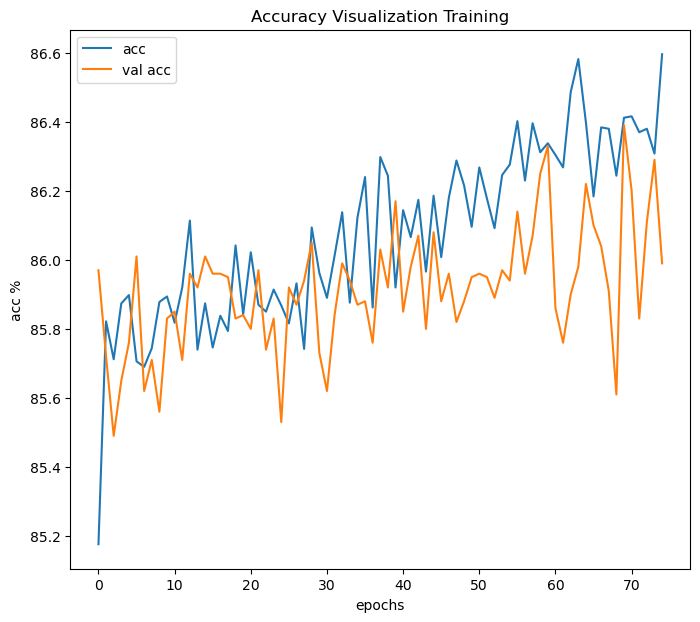

In [46]:
plt.figure(figsize = (8, 7))
plt.plot([training_history[e]['train_acc'] for e in training_history.keys()], label = 'acc')
plt.plot([training_history[e]['val_acc'] for e in training_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Accuracy Visualization Training")
plt.legend(loc = 'best')
plt.show()

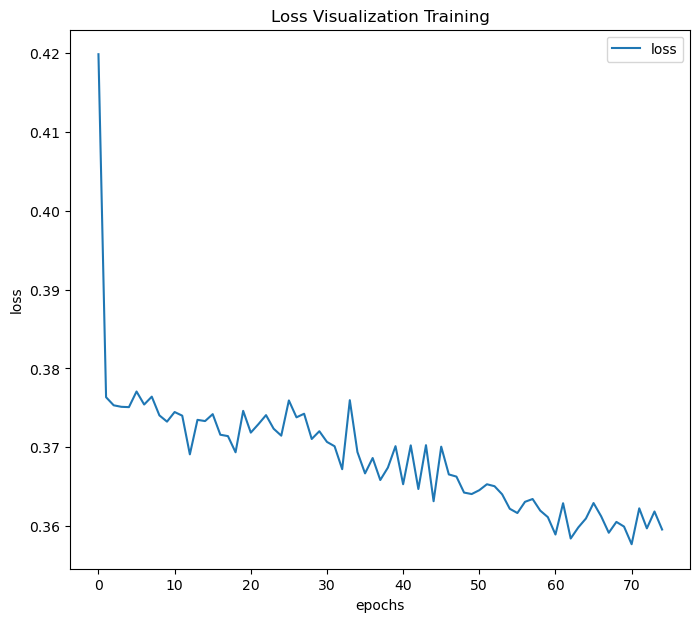

In [47]:
plt.figure(figsize = (8, 7))
plt.plot([training_history[e]['train_loss'] for e in training_history.keys()], label = 'loss')
# plt.plot([training_history[e]['val_loss'] for e in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

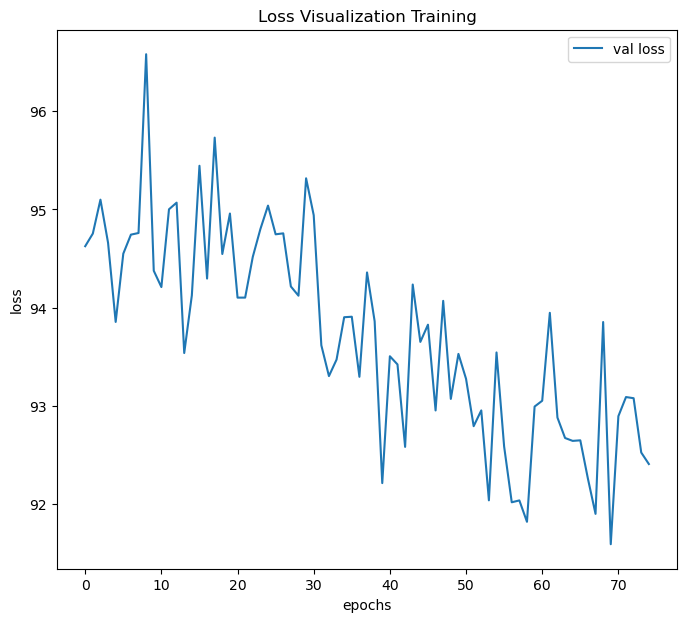

In [48]:
plt.figure(figsize = (8, 7))
# plt.plot([training_history[e]['train_loss'] for e in training_history.keys()], label = 'loss')
plt.plot([training_history[e]['val_loss'] for e in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

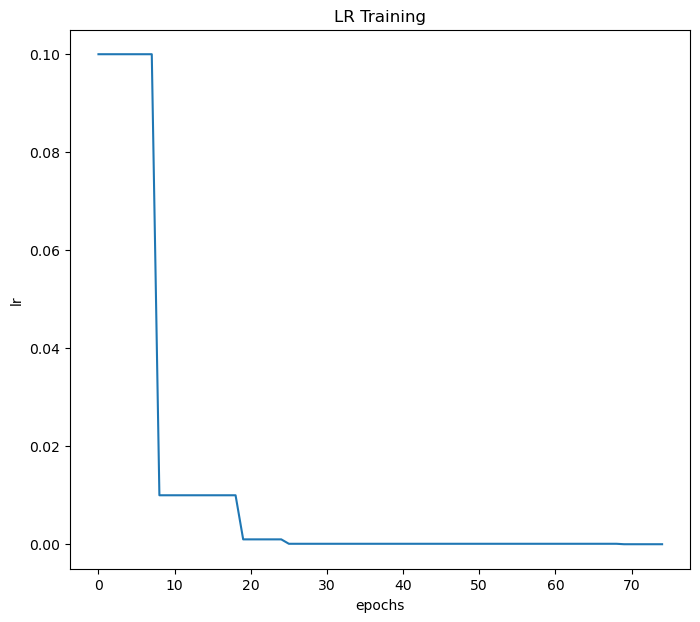

In [49]:
plt.figure(figsize = (8, 7))
plt.plot([training_history[e]['lr'] for e in training_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LR Training")
plt.show()

### Observations

[ResNet-18 CIFAR10](https://github.com/arjun-majumdar/CNN_Classifications/blob/master/ResNet18_CIFAR10_albumentations-torch.ipynb) trained from scratch achieved 91.31% validation accuracy. Whereas, using proxy task based self-supervised learning achieved 86.39% validation accuracy. This is a delta 4.71%, approximately.